<h1 align="center">
  <br>
  <a><img src="http://mastersid.univ-rouen.fr/images/logoSID.jpg" width="200"></a>
  <br>
Classification des documents du procès des groupes américains du tabac
  <br>
</h1>
<h4 align="center"> Jeremy CATELAIN</h4>

## 0. Introduction
### Contexte
Le gouvernement américain a attaqué en justice cinq grands groupes américains du tabac pour avoir amassé d'importants bénéfices en mentant sur les dangers de la cigarette. Le cigarettiers  se sont entendus dès 1953, pour "mener ensemble une vaste campagne de relations publiques afin de contrer les preuves de plus en plus manifestes d'un lien entre la consommation de tabac et des maladies graves". 

Dans ce procès 14 millions de documents ont été collectés et numérisés. Afin de faciliter l'exploitation de ces documents par les avocats, vous êtes en charge de mettre en place une classification automatique des types de documents. 

Un échantillon aléatoire des documents a été collecté et des opérateurs ont classé les documents dans des répertoires correspondant aux classes de documents : lettres, rapports, notes, email, etc. Vous avez à votre disposition : 

- les images de documents : http://data.teklia.com/Images/Tobacco3482.tar.gz
- le texte contenu dans les documents obtenu par OCR (reconnaissance automatique) : Tobacco3482-OCR.tar.gz  (dans ce git)
- les classes des documents définies par des opérateurs : Tobacco3482.csv (dans ce git)

### Introduction

Le but de ce projet est d'étudier les données que l'on a à notre disposition et trouver un ou des modèles permettant de classifier correctement les documents. Nous commencerons tout d'abord par analyser les données puis étudier quelques modèles de classification. Pour finir, nous allons analyser les résultats. Nous verrons les modèles suivants: 
- Classifieur bayésien multinomial
- MLP 
- Régression logistique
- CNN & Embedding

Les données initiales sont des images de divers documents. Ces dernières ont été traitées par un OCR et chaque image a été convertie en texte afin que nous puissons faire de l'analyse de textes et non d'images. Ainsi, les textes que l'on a ne sont pas toujours correctes en terme de parfaite retranscription, ce qui aura une influence sur la qualité de nos classification. 

### Informations

- Ce notebook est un complémentaire du script python (script.py) et du rapport (rapport.md). Contrairement au code du script, le code de ce notebook n'a pas été corrigé pour suivre le style d'écriture PEP8. Il est important de noter que ce code donne les mêmes résultats que le script python même si le format n'est pas le même. Le format a été adapté pour le notebook. Les commentaires se trouvant dans ce notebook sont complémentaires aux commentaires du rapport. Ils visent davantage à commenter les résultats du code plutôt que l'analyse synthétique des résultats (cf rapport).

- Le noyau à utiliser est "env" (fournit avec ce notebook). Le fichier requirement.txt est également joint. 
- Ce notebook doit être lu et/ou exécuter dans l'ordre. Seul le script a été adapté pour exécuter un ou plusieurs modèle à la fois.  

In [32]:
# -*- coding: utf-8 -*-
import numpy as np
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame as df
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import sklearn.model_selection  as model_selection
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Dense, Embedding, Input, Dropout, MaxPooling1D, Conv1D, Flatten
from keras.models import Model, load_model
from keras.utils import np_utils
from sklearn.metrics import accuracy_score
from keras.preprocessing import text, sequence
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from pprint import pprint
from time import time
import logging
from sklearn.neural_network import MLPClassifier
from sklearn import linear_model
from keras.preprocessing.text import Tokenizer

## 1. Analyse des données 

Tout d'abord, nous étudions le fichier csv qui a été fourni avec les données. 

In [2]:
df_classes =  pd.read_csv('data/Tobacco3482.csv', sep = ",") #Lecture du fichier de données. 
df_classes.shape #shape du fichier
df_classes.columns #le tableau contient deux colonnes: "img_path" et "label"
df_classes.describe() #summary

(3482, 2)

Index(['img_path', 'label'], dtype='object')

,img_path,label
count,3482,3482
unique,3482,10
top,Memo/2054927900_2054927901.jpg,Memo
freq,1,620


Il y a 3482 données dans le fichier Tobacco3482.csv. Ce fichier contient deux colonnes. On peut compter 10 labels différents. 

Affichons 5 éléments pris aléatoirement dans le fichier.

In [3]:
df_classes.sample(n=5) #5 éléments du fichier

,img_path,label
2260,Memo/2076900993.jpg,Memo
2543,News/2046117930.jpg,News
3193,Resume/50591446-1447.jpg,Resume
2026,Memo/2025851048_2025851049.jpg,Memo
853,Form/2024027426_7427.jpg,Form


On observe deux colonnes: le chemin d'une image ainsi que le label de cette image (nom du dossier dans lequel l'image se trouve). Ce fichier permet simplement d'obtenir le chemin et le label pour chaque document.  

In [4]:
df_classes.dropna().shape

(3482, 2)

Il y a aucune données manquantes dans le fichier csv. 

Nous disposons des textes contenus dans les documents obtenus par OCR (reconnaissance automatique). Analysons ces fichiers.

In [5]:
x = []
y= []
nb_zeros = 0
nb_words = []
keys = df_classes["label"] #tous les labels
dict_nbwords = dict(zip(keys, [0]*len(keys)))
for i in os.listdir('./data/Tobacco3482-OCR'): #sous-dossiers
        files=glob.glob('./data/Tobacco3482-OCR/'+i+'/*.txt') #fichiers dans le sous-dossier
        for file in files:
            f=open(file, 'r')
            text = f.read() #le texte
            c = len(Counter(text.split())) #nombre de mots
            if c>=3: #si il y a au moins trois mots dans le documents
                x.append(text)  #le texte
                nb_words.append(c) #nombre de mots par documents
                dict_nbwords[i] = (c + dict_nbwords[i]) / 2
                y.append(i) #nom du sous-dossier (=label)
            else: 
                nb_zeros+=1
                
nb_words_array = np.array(nb_words) 
df_nb_words = df(nb_words_array)
index = np.where(nb_words_array == nb_words_array.min())
print("Nombre de documents ayant que 3 mots = ", len(index[0]))
print("Nombre de documents ayant moins de 3 mots = ", nb_zeros)
print("Pourcentage de documents retirés = ", np.round(100*(nb_zeros)/3482,1))
df_nb_words.describe()

Nombre de documents ayant que 3 mots =  5
Nombre de documents ayant moins de 3 mots =  51
Pourcentage de documents retirés =  1.5


,0
count,3431.000000
mean,160.910230
std,124.326764
min,3.000000
25%,80.000000
50%,138.000000
75%,204.000000
max,1213.000000


Nous disposons de 3482 documents. On constate qu'en moyenne, un document a 160 mots différents. Cependant la variance est grande (124). Il est intéressant de regarder alors la médiane qui est de 138. Nous avons retiré seulement 1.5% des documents correspondant aux documents ayant au plus deux mots. On a donc décidé de garder tous les documents ayant au moins trois mots. Ce choix peut être justifié par le fait que deux mots ne suffisent pas pour classer un document. De plus, après avoir regardé ces documents, on constate que les deux seuls mots qu'ils ont, sont ininterprétables (il y a même des documents n'ayant aucun mot). 

Nous disposons maintenant de 3431 fichiers textes. Visualisons la répartition des différents labels sur l'ensemble de nos documents ainsi que la répartition approximative du nombre de mots par document.

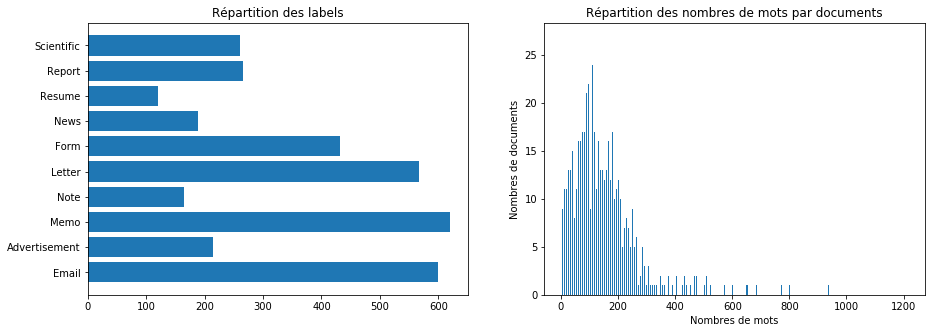

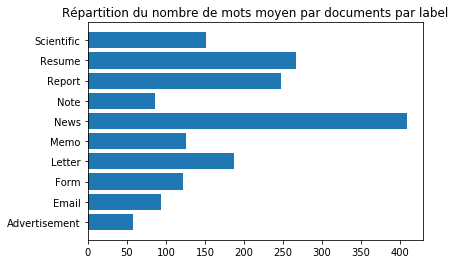

In [6]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))

c = Counter(y)
ax1.barh(list(c.keys()), list(c.values()))
ax1.set_title("Répartition des labels");

c = Counter(nb_words)
ax2.bar(list(c.keys()), list(c.values()))
ax2.set_title("Répartition des nombres de mots par documents");
ax2.set_xlabel('Nombres de mots');
ax2.set_ylabel('Nombres de documents');

plt.show()

plt.barh(list(dict_nbwords.keys()), list(dict_nbwords.values()));
plt.title("Répartition du nombre de mots moyen par documents par label");

Les trois labels les plus représentés sont Email, Letter et Memo. Les labels Resume, News et Note sont ceux qui sont les moins présents. Au regard des valeurs des occurrences, on peut dire que les labels sont plutôt bien partagés dans les données (non présence de sur-représentation). En ce qui concerne le nombre de mots par documents, on remarque que la plupart des documents ont entre 100 et 200 mots. Seuls quelques documents ont un nombre de mots supérieures à 200. On remarque que le nombre moyen de mots par documents ne différent pas considérablement entre les documents de labels différents. Seuls les documents News ont un nombre moyen deux fois plus élevés que les autres. On a donc plus d'informations pour les documents de ce label. Et en général, on a relativement le même quantité d'informations pour chaque label (car l'ordre de grandeur n'est pas très différent selon les labels (entre 50 et 100)). 

Nous avons mis dans un tableau tous les textes OCR. Ayant peu de données (<1 M d'exemples), nous sommes dans un cas classique de machine learning. On découpe alors nos données de la manière suivante: 
- 60% pour l'ensemble d'apprentissage.
- 20% pour l'ensemble de tests. 
- 20% pour l'ensemble de validation. 

Nous allons découper nos données comme décrit ci-dessus et vérifier qu'ils suivent bien la même distribution par rapport aux classes. 

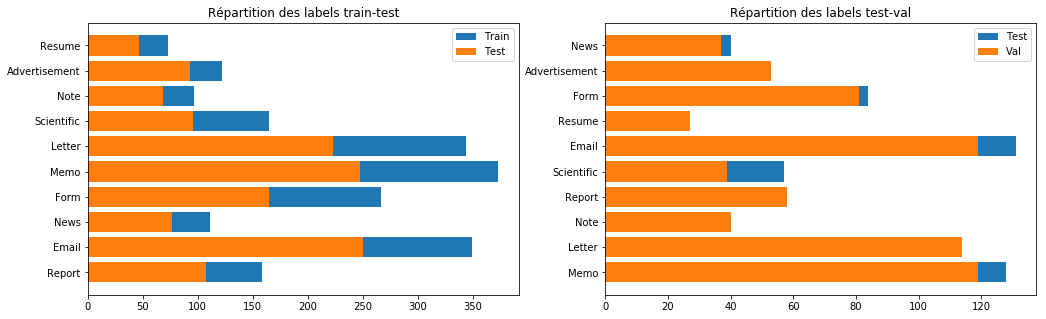

In [7]:
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.4, random_state=1)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(17,5))

c = Counter(y_train)
ax1.barh(list(c.keys()), list(c.values()))
ax1.set_title("Répartition des labels train-test");
c = Counter(y_test)
ax1.barh(list(c.keys()), list(c.values()))
ax1.legend(["Train", "Test"]);

x_test,x_val,y_test,y_val = train_test_split(x_test,y_test, test_size=0.5, random_state=1)
c = Counter(y_test)
ax2.barh(list(c.keys()), list(c.values()))
ax2.set_title("Répartition des labels test-val");
c = Counter(y_val)
ax2.barh(list(c.keys()), list(c.values()))
ax2.legend(["Test", "Val"]);

Les données d'apprentissage, de validation et de tests suivent relativement bien la même répartion par rapport aux labels. 

## 2. Classifieur bayésien multinomial

Après avoir analyser nos données, nous allons, à présent, les classifier avec différentes méthodes.

Premièrement, nous allons utiliser la représentation TF-IDF pour former un Classifieur bayésien multinomial. Ce classifieur a pour but de maximiser la classification à partir des probabilités jointes (cad occurrence simultanée d'un mot dans un document et de la classe de ce document).

Nous utilisons d'abord CountVectorizer qui encode le texte en utilisant les fréquences des mots. Cependant, les mots très fréquents et figurant dans tous les documents auront un poids important alors qu'ils ne sont pas discriminants. On utilise alors la méthode TF-IDF qui prend en compte le nombre de documents dans lesquels un mot donné apparaît. Un mot qui apparaît dans de nombreux documents aura maintenant un poids moins important. 

In [8]:
vectorizer = CountVectorizer() #on utilise l'ensemble des mots (pas de max_features pour l'instant)
vectorizer.fit(x_train) #apprendre le vocabulaire à partir des documents.
print("Taille du vocabulaire: ",len(vectorizer.vocabulary_))

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

Taille du vocabulaire:  57855


In [9]:
x_train_counts = vectorizer.transform(x_train) #encode chaque document en vecteur.
x_val_counts = vectorizer.transform(x_val) #encode chaque document en vecteur.
x_test_counts = vectorizer.transform(x_test) #encode chaque document en vecteur.
print("Train: ", x_train_counts.shape)
print("Validation: ",x_val_counts.shape)
print("Test: ",x_test_counts.shape)

Train:  (2058, 57855)
Validation:  (687, 57855)
Test:  (686, 57855)


Nous avons construit des matrices de termes-documents avec un vocabulaire de taille 57 855.

In [10]:
#le TfidfTransformer est appliqué après le CountVectorizer
tf_transformer = TfidfTransformer()
#transforme la matrice en une représentation tf-idf
x_train_tf = tf_transformer.fit_transform(x_train_counts) 
x_val_tf= tf_transformer.fit_transform(x_val_counts)
x_test_tf= tf_transformer.fit_transform(x_test_counts)

Ayant maintenant obtenu les caractéristiques des documents, nous pouvons construire un Classifieur bayésien multinomial pour essayer de prédire la classe d'un document.

In [11]:
clf = MultinomialNB()
clf.fit(x_train_tf,y_train) #apprentissage

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Nous allons maintenant évaluer notre modèle sur l'ensemble de validation.

In [12]:
score = clf.score(x_val_tf,y_val)
print("Score du modèle: ", score)

cv = model_selection.cross_val_score(clf, x_val_tf, y_val, cv=10)
moy = np.mean(cv)
var = np.std(cv)
print("Moyenne du score du modèle: ", moy)
print("Variance du score du modèle: ", var)

Score du modèle:  0.5036390101892285
Moyenne du score du modèle:  0.4646525512516364
Variance du score du modèle:  0.041892738900109125


Après une validation croisée sur l'ensemble de validation avec k=10, on trouve que le score du modèle est d'environ 50%, ce qui est relativement faible. La classification est bonne dans moins d'un cas sur 2. Cependant, le score est plus grand que si la classification se faisait aléatoirement (>1/10).

### Analyse des erreurs

Le taux d'erreur de classification donne une évaluation de la performance pour toutes les classes. Cependant, les classes ne sont pas identiquement distribuées. Pour avoir une meilleure idée de la performance du classifieur, nous allons utiliser les métriques suivantes: 
- *metrics.classification_report* qui fournit une analyse détaillée par classe: précision (parmi tous les exemples classés dans la classe X, combien appartiennent réellement à la classe X) et le rappel (parmi tous les exemples appartenant à la classe X, combien sont classés dans la classe X) et le F-Score qui correspond à la moyenne harmonique pondérée de la précision et du rappel.
- *metrics.confusion_matrix* qui donnent les confusions entre les classes.

Nous utilisons l'ensemble test pour étudier les erreurs du modèle.

In [13]:
# Rapport de classification
y_pred = clf.predict(x_test_tf)
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

Advertisement       1.00      0.10      0.18        40
        Email       0.97      0.89      0.93       131
         Form       0.68      0.43      0.53        84
       Letter       0.35      0.83      0.49       109
         Memo       0.43      0.83      0.56       128
         News       1.00      0.03      0.05        40
         Note       0.00      0.00      0.00        28
       Report       0.00      0.00      0.00        49
       Resume       0.00      0.00      0.00        20
   Scientific       0.00      0.00      0.00        57

    micro avg       0.51      0.51      0.51       686
    macro avg       0.44      0.31      0.27       686
 weighted avg       0.52      0.51      0.44       686



/home/jcatelain/Bureau/TA/env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Les  métriques calculées ne sont pas très bonnes dans l'ensemble. Seulement trois labels ont une précision de plus de 90% (Email, Advertissement et News (même 100% pour les deux derniers)). 4 labels ont une précision de 0% ce qui témoigne du mauvais apprentissage de notre modèle. Nous avons donc un cas de sur-apprentissage. On peut faire les mêmes conclusions pour les métriques Rappel et F1-score. Notre modèle ne classe donc pas bien de nouvelles données. 

Le résultat de macro average est inférieur à celui de micro pour les 3 métriques, donc les documents appartenant aux labels les moins présents dans la base de données sont mal classées, alors qu'ils sont correctement classées pour ceux apparaissant le plus.

Calculons la matrice de confusion.

In [14]:
# Matrice de confusion
matrice_confusion = confusion_matrix(y_test, y_pred)
print("Matrice de confusion: \n",matrice_confusion)

#normaliser la matrice de confusion
matrice_confusion = matrice_confusion / matrice_confusion.astype(np.float).sum(axis=1)
matrice_confusion = np.floor(matrice_confusion*100)
print("Matrice de confusion normalisé (en %): \n",matrice_confusion.astype(int))

Matrice de confusion: 
 [[  4   1   2  13  20   0   0   0   0   0]
 [  0 116   0   8   7   0   0   0   0   0]
 [  0   1  36  12  35   0   0   0   0   0]
 [  0   0   0  90  19   0   0   0   0   0]
 [  0   0   0  22 106   0   0   0   0   0]
 [  0   0   4  30   5   1   0   0   0   0]
 [  0   1   5   9  13   0   0   0   0   0]
 [  0   0   1  32  16   0   0   0   0   0]
 [  0   0   0  20   0   0   0   0   0   0]
 [  0   0   5  24  28   0   0   0   0   0]]
Matrice de confusion normalisé (en %): 
 [[10  0  2 11 15  0  0  0  0  0]
 [ 0 88  0  7  5  0  0  0  0  0]
 [ 0  0 42 11 27  0  0  0  0  0]
 [ 0  0  0 82 14  0  0  0  0  0]
 [ 0  0  0 20 82  0  0  0  0  0]
 [ 0  0  4 27  3  2  0  0  0  0]
 [ 0  0  5  8 10  0  0  0  0  0]
 [ 0  0  1 29 12  0  0  0  0  0]
 [ 0  0  0 18  0  0  0  0  0  0]
 [ 0  0  5 22 21  0  0  0  0  0]]


On constate les mêmes résultats avec la matrice de confusion. Cette dernière n'étant pas diagonale, le classifieur n'est donc pas très bon.

En conclusion, notre modèle ne fonctionne pas très bien malgré un score de 50%. Nous allons donc chercher à l'améliorer en optimisant les hyperparamètres. 

### Optimisation des hyperparamètres

Nous allons optimiser les paramètres de la classification en effectuant une recherche sur grille à l'aide de GridSearchCV. Voici les différents paramètres que l'on va traiter: 
- alpha, le paramètre de lissage pour le classifieur  bayésien. 
- max_features, le nombre maximal de termes les plus fréquents à prendre en compte
- max_df, le seuil à partir duquel on ignore les termes (ceux qui apparaissent dans plus de max_df% des documents).
- utilisation de la répresentation idf ou non. 
- définition de ngram pour le CountVectorizer of TfIDF transformer (unigramme, bigramme..). 

In [15]:
# affichage des logs
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')


pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])


parameters = {
    'vect__max_df': (0.3, 0.4, 0.5, 0.7, 0.8),
    'vect__max_features' : (1000, 1500, 2000, 2500),
    'tfidf__use_idf': (True, False),
    'vect__ngram_range': ((1, 1), (1, 2)), # unigramme ou bigramme
    'clf__alpha': (1, 0.5, 0.1, 0.01, 0.001)
}


grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=2, cv=3)
print("Performing grid search...")
print("Pipeline:", [name for name, _ in pipeline.steps])
print("Paramètres:")
pprint(parameters)
t0 = time()
grid_search.fit(x_train, y_train)
print("fait en %0.3fs" % (time() - t0))
print()

Performing grid search...
Pipeline: ['vect', 'tfidf', 'clf']
Paramètres:
{'clf__alpha': (1, 0.5, 0.1, 0.01, 0.001),
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.3, 0.4, 0.5, 0.7, 0.8),
 'vect__max_features': (1000, 1500, 2000, 2500),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  7.3min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'vect__max_df': (0.3, 0.4, 0.5, 0.7, 0.8), 'vect__max_features': (1000, 1500, 2000, 2500), 'tfidf__use_idf': (True, False), 'vect__ngram_range': ((1, 1), (1, 2)), 'clf__alpha': (1, 0.5, 0.1, 0.01, 0.001)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

fait en 437.779s



In [16]:
print("Meilleur score: %0.3f" % grid_search.best_score_)
print("Meilleur paramètres:")
best_estimator = grid_search.best_estimator_
best_parameters = best_estimator.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name])) 

Meilleur score: 0.737
Meilleur paramètres:
	clf__alpha: 0.1
	tfidf__use_idf: False
	vect__max_df: 0.4
	vect__max_features: 1000
	vect__ngram_range: (1, 2)


Après avoir faire une recherche des meilleurs paramètres, on trouve un meilleur modèle avec un score de 0.72. Ce nouveau modèle n'utilise pas la représentation idf et ignore les termes apparaissant dans plus 55% des documents. Les bigrammes sont utilisés. 

Evaluons à présent notre nouveau modèle sur l'ensemble de validation.

In [17]:
score = best_estimator.score(x_val,y_val)
print("Score du modèle: ", score)

cv = model_selection.cross_val_score(best_estimator, x_val, y_val, cv=10)
moy = np.mean(cv)
var = np.std(cv)
print("Moyenne du score du modèle: ", moy)
print("Variance du score du modèle: ", var)

Score du modèle:  0.7088791848617176
Moyenne du score du modèle:  0.7028665339528963
Variance du score du modèle:  0.04886320575790256


Le score est très proche du score trouvé avec l'ensemble d'apprentissage (73%). En moyenne avec la validation-croisée, un score de 68% est trouvé, ce qui est plutôt correct. 

Etudions les erreurs du modèle avec l'ensemble test.

In [18]:
# Rapport de classification
y_pred =  best_estimator.predict(x_test)
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

Advertisement       0.73      0.68      0.70        40
        Email       0.94      0.95      0.95       131
         Form       0.74      0.79      0.76        84
       Letter       0.63      0.77      0.69       109
         Memo       0.70      0.71      0.71       128
         News       0.68      0.75      0.71        40
         Note       0.53      0.32      0.40        28
       Report       0.55      0.37      0.44        49
       Resume       0.95      1.00      0.98        20
   Scientific       0.73      0.61      0.67        57

    micro avg       0.74      0.74      0.74       686
    macro avg       0.72      0.69      0.70       686
 weighted avg       0.73      0.74      0.73       686



Les résultats sont beaucoup mieux. On retrouve le même score qu'avec les données d'apprentissage. En moyenne, le rappel, la précésion et le f1-score sont de 73%. Lesrésultatsde macro et de micro average pour les 3 métriques sont plutôt similaires donc le système prédit bien tous les labels, peu importe leur répartition dans la base de données.

In [19]:
# Matrice de confusion
matrice_confusion = confusion_matrix(y_test, y_pred)
print("Matrice de confusion: \n",matrice_confusion)

#normaliser la matrice de confusion
matrice_confusion = matrice_confusion / matrice_confusion.astype(np.float).sum(axis=1)
matrice_confusion = np.floor(matrice_confusion*100)
print("Matrice de confusion normalisé (en %): \n",matrice_confusion.astype(int))

Matrice de confusion: 
 [[ 27   2   3   4   2   1   1   0   0   0]
 [  0 125   0   4   2   0   0   0   0   0]
 [  2   1  66   5   6   0   3   1   0   0]
 [  0   0   2  84  14   1   0   6   0   2]
 [  0   4   2  19  91   1   2   5   0   4]
 [  3   0   2   0   1  30   1   2   0   1]
 [  3   1   2   7   5   0   9   0   1   0]
 [  1   0   0   8   6  10   0  18   0   6]
 [  0   0   0   0   0   0   0   0  20   0]
 [  1   0  12   3   3   1   1   1   0  35]]
Matrice de confusion normalisé (en %): 
 [[ 67   1   3   3   1   2   3   0   0   0]
 [  0  95   0   3   1   0   0   0   0   0]
 [  5   0  78   4   4   0  10   2   0   0]
 [  0   0   2  77  10   2   0  12   0   3]
 [  0   3   2  17  71   2   7  10   0   7]
 [  7   0   2   0   0  75   3   4   0   1]
 [  7   0   2   6   3   0  32   0   5   0]
 [  2   0   0   7   4  25   0  36   0  10]
 [  0   0   0   0   0   0   0   0 100   0]
 [  2   0  14   2   2   2   3   2   0  61]]


On constate les mêmes résultats avec la matrice de confusion. Cette dernière est plutôt diagonale, le classifieur est donc relativement bon.

En conclusion, nous avons trouvé un meilleur modèle grâce à l'optimisation des hyperparamètres. En effet, le score a été augmenté de plus de 20 points.

##  3. Classification avec un MLP

Nous allons utilisé un autre type de modèle: celui des réseaux de neurones. Ces derniers peuvent être formés pour apprendre à la fois la représentation vectorielle des mots (au lieu de tf-idf) et la façon de classer les documents. 

In [42]:
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.4, random_state=1)
x_test,x_val,y_test,y_val = train_test_split(x_test,y_test, test_size=0.5, random_state=1)

vectorizer = CountVectorizer(max_features=best_parameters["vect__max_features"], max_df=best_parameters["vect__max_df"], ngram_range=best_parameters["vect__ngram_range"]) #on réutilise les meilleurs paramètres
vectorizer.fit(x_train) 

x_train_counts = vectorizer.transform(x_train) 
x_val_counts = vectorizer.transform(x_val) 
x_test_counts = vectorizer.transform(x_test)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.4, max_features=1000, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

Nous allons tout d'abord utiliser un Perceptron multicouches avec le sklearn.neural_network.MLPClassifier. Après avoir testé différentes valeurs pour les paramètres suivants: 
- le nombre de couches et le nombre de neurones par couches
- le nombre d'itérations
- alpha, paramètre de régularisation
- fonction d'activation

le meilleur modèle trouvé est le suivant:

In [53]:
mlp = MLPClassifier(activation="relu",hidden_layer_sizes=(300,), max_iter=20, solver='adam', batch_size=10, verbose=1)

mlp.fit(x_train_counts, y_train)

Iteration 1, loss = 1.05549440
Iteration 2, loss = 0.33497034
Iteration 3, loss = 0.17652233
Iteration 4, loss = 0.10359152
Iteration 5, loss = 0.07480610
Iteration 6, loss = 0.05526966
Iteration 7, loss = 0.04362564
Iteration 8, loss = 0.03677205
Iteration 9, loss = 0.03214060
Iteration 10, loss = 0.02747560
Iteration 11, loss = 0.02523430
Iteration 12, loss = 0.02376967
Iteration 13, loss = 0.02130671
Iteration 14, loss = 0.02045178
Iteration 15, loss = 0.02017911
Iteration 16, loss = 0.01856318
Iteration 17, loss = 0.01754102
Iteration 18, loss = 0.01737920
Iteration 19, loss = 0.01685487
Iteration 20, loss = 0.01598886


/home/jcatelain/Bureau/TA/env/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size=10, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(300,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=20, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=1, warm_start=False)

Nous avons donc pris un MLP avec une couche de 300 neurones et utilisé la fonction d'activation "relu" ainsi que l'optimiseur "adam" (rmsprop + momentum) avec un batch de taille 10 et un paramètre de régularisation valant 0.0001. 

Au bout de 20 itérations, le coût est de seulement 0.01. Evaluons à présent notre modèle sur l'ensemble de validation.

In [54]:
score = mlp.score(x_val_counts,y_val)
print("Score du modèle: ", score)

Score du modèle:  0.7787481804949054


Le score est très bon (78%). Il est bien meilleur que les précédents modèles. Etudions les erreurs du modèle avec l'ensemble test.

In [23]:
# Rapport de classification
y_pred =  mlp.predict(x_test_counts)
print(classification_report(y_test, y_pred))

# Matrice de confusion
matrice_confusion = confusion_matrix(y_test, y_pred)
#normaliser la matrice de confusion
matrice_confusion = matrice_confusion / matrice_confusion.astype(np.float).sum(axis=1)
matrice_confusion = np.floor(matrice_confusion*100)
print("Matrice de confusion normalisé (en %): \n",matrice_confusion.astype(int))

               precision    recall  f1-score   support

Advertisement       0.71      0.75      0.73        40
        Email       0.93      0.97      0.95       131
         Form       0.82      0.86      0.84        84
       Letter       0.73      0.81      0.77       109
         Memo       0.84      0.68      0.75       128
         News       0.81      0.75      0.78        40
         Note       0.51      0.68      0.58        28
       Report       0.53      0.51      0.52        49
       Resume       1.00      1.00      1.00        20
   Scientific       0.61      0.58      0.59        57

    micro avg       0.77      0.77      0.77       686
    macro avg       0.75      0.76      0.75       686
 weighted avg       0.78      0.77      0.77       686

Matrice de confusion normalisé (en %): 
 [[ 75   0   2   0   0   0  21   0   0   1]
 [  0  96   0   2   0   0   3   0   0   0]
 [  5   0  85   3   1   0  14   0   0   0]
 [  2   2   1  80   7   2   0   8   0   1]
 [  5   3   4 

Les valeurs des précisions sont très bonnes. Le modèle prédit bien tous les labels (la précision est légèrement plus faible pour le label Note). En moyenne, le rappel, la précision et le f1-score sont de 76%, ce qui est meilleur que les précédents modèles. Les résultats de macro et de micro average pour les 3 métriques sont plutôt similaires donc le système prédit bien tous les labels, peu importe leur répartition dans la base de données. 

On constate les mêmes résultats avec la matrice de confusion. Cette dernière est plutôt diagonale, le classifieur est donc relativement bon (et meilleur que les précedents modèles). 

## 4. Classification avec régression logistique
Nous allons maintenant étudier la méthode de régression logistique (régression + fonction logistique) qui diffère légèrement du Classifieur multinomial bayésien. En effet, celui-ci a pour but de maximiser la classification à partir des probabilités conditionnelles (et non jointes).

In [33]:
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.4, random_state=1)
x_test,x_val,y_test,y_val = train_test_split(x_test,y_test, test_size=0.5, random_state=1)

vectorizer = CountVectorizer(max_features=best_parameters["vect__max_features"], max_df=best_parameters["vect__max_df"], ngram_range=best_parameters["vect__ngram_range"]) #on réutilise les meilleurs paramètres
vectorizer.fit(x_train) 

x_train_counts = vectorizer.transform(x_train) 
x_val_counts = vectorizer.transform(x_val) 
x_test_counts = vectorizer.transform(x_test)


lr = linear_model.LogisticRegression()
lr.fit(x_train_counts, y_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.4, max_features=1000, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Calculons le score du modèle sur les données d'évaluation.

In [25]:
score = lr.score(x_val_counts,y_val)
print("Score du modèle: ", score)

Score du modèle:  0.7583697234352256


Le score est de 76%, ce qui est très bon en comparant avec les résultats précédents.

In [26]:
# Rapport de classification
y_pred =  lr.predict(x_test_counts)
print(classification_report(y_test, y_pred))

# Matrice de confusion
matrice_confusion = confusion_matrix(y_test, y_pred)
#normaliser la matrice de confusion
matrice_confusion = matrice_confusion / matrice_confusion.astype(np.float).sum(axis=1)
matrice_confusion = np.floor(matrice_confusion*100)
print("Matrice de confusion normalisé (en %): \n",matrice_confusion.astype(int))

               precision    recall  f1-score   support

Advertisement       0.68      0.70      0.69        40
        Email       0.94      0.97      0.95       131
         Form       0.83      0.85      0.84        84
       Letter       0.74      0.79      0.76       109
         Memo       0.80      0.77      0.79       128
         News       0.76      0.70      0.73        40
         Note       0.53      0.71      0.61        28
       Report       0.50      0.39      0.44        49
       Resume       1.00      1.00      1.00        20
   Scientific       0.61      0.54      0.57        57

    micro avg       0.77      0.77      0.77       686
    macro avg       0.74      0.74      0.74       686
 weighted avg       0.77      0.77      0.77       686

Matrice de confusion normalisé (en %): 
 [[ 70   1   2   0   0   0  21   2   0   1]
 [  0  96   0   2   0   0   3   0   0   0]
 [  7   0  84   3   0   0  14   2   0   1]
 [  2   2   0  78  10   2   0   6   0   1]
 [  2   2   2 

Les valeurs des précisions sont très bonnes. Le modèle prédit bien tous les labels (la précision est plus de 50% pour tous les labels). En moyenne, le rappel, la précision et le f1-score sont de 77%. Les résultats de macro et de micro average pour les 3 métriques sont plutôt similaires donc le système prédit bien tous les labels, peu importe leur répartition dans la base de données. On constate les mêmes résultats avec la matrice de confusion. Cette dernière est plutôt diagonale, le classifieur est donc relativement bon (et meilleur que les précedents modèles). 

## 5. Classification avec un CNN

Nous allons maintenant créer un classifieur de texte avec un réseau de neurones à convolutions en utilisant un plongement de mots (word embedddings). On utilise un réseau à convolutions avec une grille d'une dimension car nos données sont des séquences. Ce type de réseau part du principe que la détection de feature est important pour la classficiation.

In [34]:

def get_train_test(train_raw_text, test_raw_text):
    
    tokenizer = text.Tokenizer(num_words=MAX_FEATURES)

    tokenizer.fit_on_texts(list(train_raw_text))
    train_tokenized = tokenizer.texts_to_sequences(train_raw_text)
    test_tokenized = tokenizer.texts_to_sequences(test_raw_text)
    return sequence.pad_sequences(train_tokenized, maxlen=MAX_TEXT_LENGTH), \
           sequence.pad_sequences(test_tokenized, maxlen=MAX_TEXT_LENGTH)

def get_model():

    inputs = Input(shape=(MAX_TEXT_LENGTH,))
    model = Embedding(MAX_FEATURES, EMBED_SIZE, input_length=MAX_TEXT_LENGTH)(inputs)
    model = Dropout(0.5)(model)
    model = Conv1D(NUM_FILTERS, 5, padding='same', activation='relu')(model)
    model = MaxPooling1D(pool_size=30)(model)
    model = Flatten()(model)
    model = Dense(n_out, activation="softmax")(model)
    model = Model(inputs=inputs, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

Choississons les paramètres du modèles: 
- la taille du vocabulaire
- la longueur maximale des textes
- la taille de la couche Embedding
- le nombre de filtres pour le CNN
- la taille du batch

Après plusieurs tests, les paramètres amenant à un meilleur score sont les suivants: 

In [35]:
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.4, random_state=1)

# Model parameters
MAX_FEATURES = 2000 #taille du vocabulaire
MAX_TEXT_LENGTH = 1213 #nombre max approximative de mots trouvé durant l'analyse
EMBED_SIZE  = 300 
BATCH_SIZE = 16
NUM_FILTERS = 125
EPOCHS = 10
VALIDATION_SPLIT = 0.1

On transforme les textes en séquence et on effectue un padding. 

In [36]:
# Get the list of different classes
CLASSES_LIST = np.unique(y_train)
n_out = len(CLASSES_LIST)

# Convert clas string to index
le = preprocessing.LabelEncoder()
le.fit(CLASSES_LIST)
y_train = le.transform(y_train) 
y_test = le.transform(y_test) 
train_y_cat = np_utils.to_categorical(y_train, n_out)

# get the textual data in the correct format for NN
x_vec_train, x_vec_test = get_train_test(x_train, x_test)
print(len(x_vec_train), len(x_vec_test))

LabelEncoder()

2058 1373


Nous avons préparer les données. On peut maintenant entraîner notre modèle. 

In [37]:
# define the NN topology
model = get_model()

callbacks = [ModelCheckpoint("weights.hdf5", save_best_only=True, save_weights_only=True, monitor='val_acc', mode='max')]


model.fit(x_vec_train, train_y_cat,batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=VALIDATION_SPLIT, callbacks=callbacks)

model.save('modele.h5')  
del model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1213)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1213, 300)         600000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1213, 300)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1213, 125)         187625    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 40, 125)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                50010     
Total para

Après 10 itérations, le coût a légèrement diminué et la précision est de 98%, signifiant que le modèle a très bien appris les données d'apprentissage.

Evaluons notre modèle sur les données tests.

In [38]:
model = load_model('modele.h5')
model.load_weights('weights.hdf5')

y_predicted = model.predict(x_vec_test).argmax(1)
print("Score du modèle:", accuracy_score(y_test, y_predicted))

Score du modèle: 0.7428987618353969


Le score est de 74%, ce qui est cohérent avec les résultats des autres méthodes. 

In [39]:
# Rapport de classification
print(classification_report(y_test, y_predicted))

# Matrice de confusion
matrice_confusion = confusion_matrix(y_test, y_predicted)
#normaliser la matrice de confusion
matrice_confusion = matrice_confusion / matrice_confusion.astype(np.float).sum(axis=1)
matrice_confusion = np.floor(matrice_confusion*100)
print("Matrice de confusion normalisé (en %): \n",matrice_confusion.astype(int))

              precision    recall  f1-score   support

           0       0.60      0.52      0.55        93
           1       0.91      0.94      0.92       250
           2       0.73      0.73      0.73       165
           3       0.77      0.79      0.78       223
           4       0.83      0.83      0.83       247
           5       0.72      0.66      0.69        77
           6       0.49      0.51      0.50        68
           7       0.47      0.49      0.48       107
           8       0.98      0.96      0.97        47
           9       0.57      0.57      0.57        96

   micro avg       0.74      0.74      0.74      1373
   macro avg       0.71      0.70      0.70      1373
weighted avg       0.74      0.74      0.74      1373

Matrice de confusion normalisé (en %): 
 [[51  1  3  1  0  6 35  0  0  2]
 [ 0 93  0  3  0  0  5  1  0  0]
 [10  2 72  1  3  0  7  5  0  7]
 [ 0  0  2 78  6  1  1 18  0  4]
 [ 1  3  3  7 82  3  2  3  0  2]
 [ 8  0  1  1  1 66  0  5  0  4]
 [

Les valeurs des précisions sont très bonnes. Le modèle prédit bien tous les labels (la précision est plus de 50% pour tous les labels). En moyenne, le rappel, la précision et le f1-score sont de 74%. Les résultats de macro et de micro average pour les 3 métriques sont plutôt similaires donc le système prédit bien tous les labels, peu importe leur répartition dans la base de données. On constate les mêmes résultats avec la matrice de confusion. Cette dernière est plutôt diagonale, le classifieur est donc relativement bon (et meilleur que les précedents modèles). 

## 6. Conclusion

### Analyses des résultats
Voici les scores trouvés pour les différents modèles utilisés. 

| Modèle      |     Weight average    |   Score |
| ------------- |: -------------: | ---------: |
| MultinomialNB      |        73%        |      71% |
| MLPClassifier        |        78%        |      78% |
| LogisticRegression      |       77%        |      76% |
| CNN + Embedding      |        74%        |      74% |

Nous pouvons donc dire que les modèles crées donnent relativement les mêmes résultats. Le meilleur modèle semble être celui de MLP. Le moins bon est celui avec le classifieur bayéssien (alors qu'il a été optimisé). La représentation TF_IDF ainsi que les probabilités jointes ne semblent donc pas être les meilleures méthodes à appliquer pour faire de la classification sur nos données, alors que les réseaux de neurones (MLP ou CNN) et la régression semble être les meilleurs méthodes.

En moyenne, on peut dire que la précision d'un modèle est de 75%. En ayant créée 4 modèles, on peut voir que les précisions sont très proches même avec une optimisation. On peut donc supposer que l'on est proche du niveau de précision maximale qu'un modèle peut atteindre avec ces données. 

On a aussi pu remarquer que les modèles prédisent très bien certaines classes contrairement à d'autres. Pour toutes les méthodes, les meilleurs labels prédits sont Email et Resume. Les moins bien prédits sont Note et Report. Ces résultats sont intéressants: 

* Email est le label le plus représenté alors que Resumé est celui le moins représenté. Cependant, ils sont tous les deux les mieux prédit. Le résultat est donc dû à la qualité des textes OCR ou de la quantité d'informations dans les documents. On a pu remarqué que Resume faisait partie des documents ayant le plus de mots par documents tandis qu'il s'agit du contraire pour Email. On a donc deux cas opposés ayant la même qualité de prédiction. On en conclut que: Resume est peu représenté mais sur ce peu de documents, les textes contiennent beaucoup de mots et probablement de bonnes qualités. En ce qui concerne Email, ce label a beaucoup de documents mais chaque document contient très peu de mots. Cependant, il est probable que ces mots soient de très bonnes qualités en terme d'OCR ou d'informations. Cette analyse est plutôt logique car les emails sont des textes courts facile à traiter puisqu'il s'agit d'écritures numériques.

* Note et Report sont moyennement représentés. Report a légèrement plus de documents. Cependant, Note a beaucoup de mots que Report. Leurs scores sont de 50%. Ce résultat n'est pas mauvais mais n'est pas le meilleur. Ce score est correct puisqu'il est supérieur à l a probabilité de tirer aléatoirement un label parmi les 10. On peut dire que les documents Note ont peu de mots et que ces derniers sont de mauvaises qualités en terme d'OCR ou d'informations. Il est aussi probable que les documents Report contiennent beaucoup de mots mais que très peu soient de qualités. 

On peut donc dire que les résultats sont biaisés par la qualité de la technique OCR mais aussi de la qualité des informations dans les documents. 



### Piste d'améliorations

Nous avons pu voir que le modèle Perceptron Multi-Couche est le meilleur. On pourrait l'améliorer davantage en utilisant Keras avec des couches Dense et d'autres fonctions d'activation que celles proposées par sklearn.MLP. Nous ne connaissons pas d'autres modèles pour traiter ce genre de problème (classification de texte). La meilleur méthode pour améliorer nos précisions est la modification des données traitées. Il serait notamment judicieux d'essayer d'améliorer  la technique OCR utilisée. En effet, certaines images ont été très mal retranscriptes. Certaines textes sont vides ou ininterprétables.

La technique OCR pourrait être par exemple un réseau de neurones à convolutions en deux dimensions (traiter les caractéristiques) associé à un réseau de neurones récurrents (pour traiter le contexte). On pourrait tester cette technique avec un modèle CTC (traitement de séquences). Par exemple, pour le projet du cours de Sequential Data Analysis, le modèle que j'ai crée (CNN+RNN avec CTC) a atteint un taux de bonne reconnaissance de mots sur des images égal à 60% et un taux de bonne reconnaissance de caractère égal à 73% (résultats sont cohérents avec ceux trouvés par les chercheurs dans ce domaine). 

De plus, il serait aussi nécéssaire d'avoir des données avec une meilleur répartition. Il faudrait alors avoir plus de données afin d'avoir une répartition des labels plutôt similaires dans les données.
